In [1]:
import copy
import collections
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import py3Dmol
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolAlign
from rdkit.Chem import PeriodicTable
from rdkit.Chem.Lipinski import RotatableBondSmarts
import scipy
from scipy import spatial as sci_spatial
import torch
from tqdm.auto import tqdm
# import seaborn as sns

ptable = Chem.GetPeriodicTable()

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')  

from core.evaluation.utils import eval_bond_length, scoring_func, similarity

/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

In [2]:
from eval_utils import ModelResults

result_dir = '/sharefs/share/sbdd_data/all_results'

ref_path = os.path.join(result_dir, 'crossdocked_test_vina_docked.pt')
ar_path = os.path.join(result_dir, 'ar_vina_docked.pt')
tg_path = os.path.join(result_dir, 'targetdiff_vina_docked.pt')
p2m_path = os.path.join(result_dir, 'pocket2mol_vina_docked.pt')
bfn_path = os.path.join(result_dir, 'bfn_vina_docked.pt')
train_path = os.path.join(result_dir, 'train_vina_docked.pt')
dcmp_path = os.path.join(result_dir, '4-decompdiff_docked.pt')
dcmp_ref_path = os.path.join(result_dir, '4-decompdiff_ref_docked.pt')

# TODO: check which is the correct file
bfn_path = os.path.join(result_dir, 'bfn_mols_v10_vina_docked.pt')

ref = ModelResults('Reference', ref_path)
ar = ModelResults('AR', ar_path)
p2m = ModelResults('Pocket2Mol', p2m_path)
tg = ModelResults('TargetDiff', tg_path)
dcmp = ModelResults('DecompDiff-Pocket', dcmp_path)
dcmp_ref = ModelResults('DecompDiff-Ref', dcmp_ref_path)
bfn = ModelResults('BFN', bfn_path)

ref.load_pose_checked()
ar.load_pose_checked()
p2m.load_pose_checked()
tg.load_pose_checked()
dcmp.load_pose_checked()
dcmp_ref.load_pose_checked()

bfn.load_pose_checked()
bfn.remove_incomplete()


reference loaded 100 vina docked results
Reference loaded 100 pose checked results
AR loaded 9295 pose checked results
Pocket2Mol loaded 9831 pose checked results
TargetDiff loaded 9036 pose checked results
DecompDiff-Pocket loaded 7196 pose checked results
DecompDiff-Ref loaded 8290 pose checked results
bfn_complete loaded 383 pose checked results
bfn_complete has 383 ligands in total
bfn_complete has 381 complete ligands left
bfn_mols loaded 9650 pose checked results
bfn_mols has 9650 ligands in total
bfn_mols has 9648 complete ligands left
BFN loaded 9600 pose checked results
BFN has 9600 ligands in total
BFN has 9597 complete ligands left
bfn_pi loaded 977 vina docked results
bfn_pi has 977 ligands in total
bfn_pi has 975 complete ligands left


In [3]:
models = [ar, p2m, tg, dcmp, dcmp_ref, bfn]


## Ring Size

In [ ]:
models = [ar, p2m, tg, dcmp, dcmp_ref, bfn]
x_ref, y_ref = [], []
for _size, ratio in ref.ring_size_profile.items():
    x_ref.append(_size)
    y_ref.append(ratio)

color_mapping = {
    'Reference': 'grey',
    'AR': 'blue',
    'Pocket2Mol': 'green',
    'TargetDiff': 'orange',
    'DecompDiff-Pocket': 'red',
    'DecompDiff-Ref': 'pink',
    # 'bfn_complete': 'brown',
    # 'bfn_mols': 'pink',
    'BFN': 'purple',
}

# plt.figure(figsize=(6*4, 4*2))
for idx, model in enumerate(models):
    plt.figure()
    # plt.subplot(2, 4, idx+1)
    x, y = [], []
    for _size, ratio in model.ring_size_profile.items():
        x.append(_size)
        y.append(ratio)
    plt.bar(x_ref, y_ref, label='Reference', alpha=0.5, color='grey')
    plt.bar(x, y, label=f'{model.name}', color=color_mapping[model.name], alpha=0.5)
    plt.ylim(0, 0.9)
    plt.title(f'{model.name}')
plt.legend()
plt.show()


In [ ]:
import pandas as pd
df = pd.read_csv('agg.csv')

# only take column ring_size
df = df[['model', 'ring_size']]
# split ring_size into multiple columns and add prefix
# rename according to a dict
predix_mapping = {
    'ring_size_0': 3,
    'ring_size_1': 4,
    'ring_size_2': 5,
    'ring_size_3': 6,
    'ring_size_4': 7,
    'ring_size_5': 8,
    'ring_size_6': 9,
}
df = df.join(df['ring_size'].str.split(',', expand=True).add_prefix('ring_size_'))
# drop original ring_size column
df = df.drop(columns=['ring_size'])
df = df.rename(columns=predix_mapping)
# for each column remove possible '[' and ']'
for col in df.columns:
    if col == 'model': continue
    df[col] = df[col].str.replace('[', '')
    df[col] = df[col].str.replace(']', '')
    df[col] = df[col].astype(float)
    # change to percentage and add percentage character
    df[col] = df[col] * 100
    # set it to 3 decimal places
    df[col] = df[col].round(2)
    df[col] = df[col].astype(str) + '%'
df
df.to_csv('agg_clean.csv', index=False)

## Distance & Bond Length

(6, 6, 1), #	CC	716	29.6%	1.2857153558712793	1.696778883283098	0.004110635274118186
(6, 6, 4), #	C:C	500	20.7%	1.2981754588686738	1.5429516779717267	0.002447762191030529
(6, 8, 1), #	CO	336	13.9%	1.217717567891834	1.592581263775381	0.0037486369588354694
(6, 7, 1), #	CN	245	10.1%	1.2412786652760066	1.609101379383609	0.0036782271410760246
(6, 7, 4), #	C:N	213	8.8%	1.2781037555594505	1.4881754271876604	0.002100716716282098


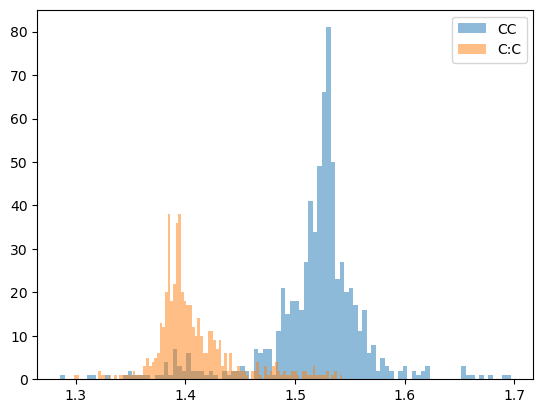

In [3]:
from core.evaluation.utils import eval_bond_length

bond_lengths = []
for res in ref.flat_results:
    mol = res['mol']
    mol = Chem.RemoveAllHs(mol)
    bond_lengths += eval_bond_length.bond_distance_from_mol(mol)

profile = eval_bond_length.get_bond_lengths(bond_lengths)

N_BINS = 100

# plt.hist(ref.all_c_c_distance, bins=N_BINS, label='all c c pairs', alpha=0.5)

allowed_bond_types = []
for k, v in sorted(profile.items(), key=lambda x: len(x[1]), reverse=True):
    freq = len(v)
    rate = freq / len(bond_lengths) * 100
    if freq < 10:
        continue

    if freq > 200:
        allowed_bond_types.append(k)
        bond_type_str = eval_bond_length._bond_type_str(k)
        if k[0] == k[1] == 6:
            plt.hist(profile[k], bins=N_BINS, label=bond_type_str, alpha=0.5)
        min_val, max_val = np.min(profile[k]), np.max(profile[k])
        bin_width = (max_val - min_val) / N_BINS
        print(f'{k}, #\t{bond_type_str}\t{freq}\t{rate:.1f}%\t{min_val}\t{max_val}\t{bin_width}')

plt.legend()
plt.show()

In [4]:
models = [ar, p2m, tg, dcmp, dcmp_ref, bfn]
profiles = []

ref_profile = profile
N_BINS = 100

for model in models:
    bond_lengths = []
    for res in model.flat_results:
        mol = res['mol']
        mol = Chem.RemoveAllHs(mol)
        bond_lengths += eval_bond_length.bond_distance_from_mol(mol)
    profiles.append(eval_bond_length.get_bond_lengths(bond_lengths))


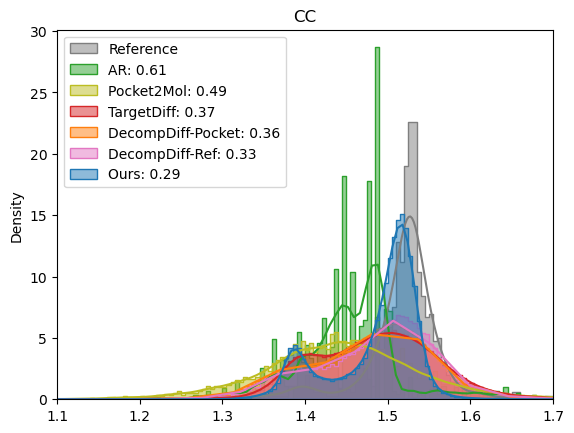

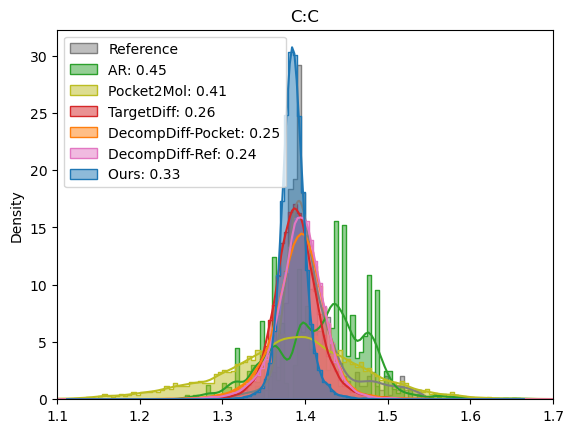

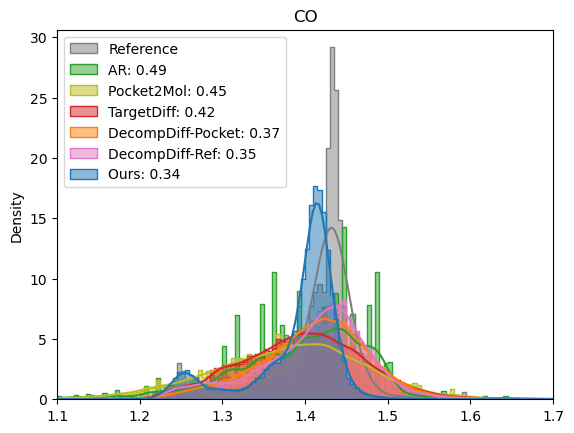

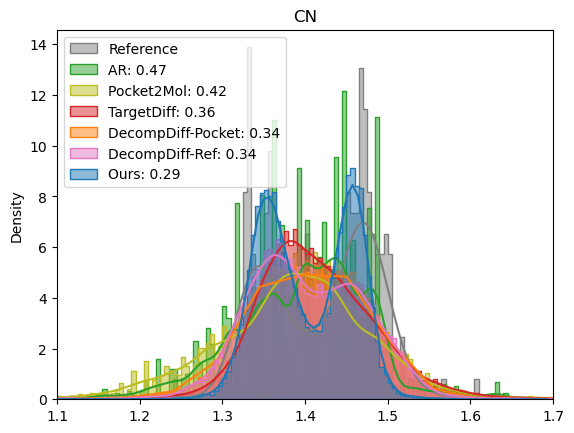

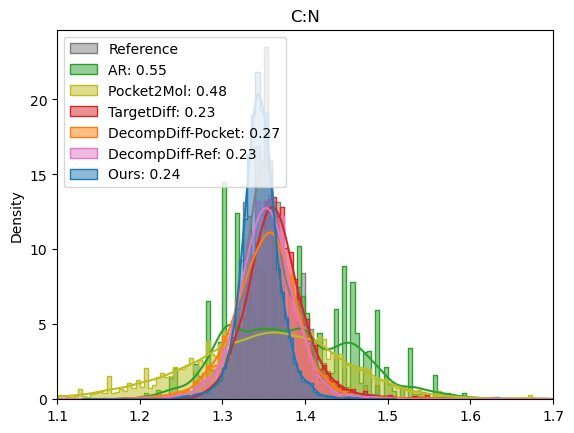

In [5]:
from scipy import spatial as sci_spatial
import seaborn as sns
# from core.evaluation.utils import discrepancy

BOND_LENGTH_BINS = np.arange(1.1, 1.7005, 0.005)
BOND_RANGE = (1.1, 1.7)
colors = ['tab:gray', 'tab:green', 'tab:olive', 'tab:red', 'tab:orange', 'tab:pink', 'tab:blue', 'tab:cyan', 'tab:purple', 'tab:gray', 'tab:brown'] 

models[-1].name = 'Ours'

for bond_type in allowed_bond_types:
    plt.figure()
    ref_min, ref_max = np.min(ref_profile[bond_type]), np.max(ref_profile[bond_type])
    ax = sns.histplot(ref_profile[bond_type], bins=BOND_LENGTH_BINS, label='Reference', alpha=0.5, color=colors[0], stat='density', kde=True, element='step')
    ax.set_xlim(BOND_RANGE)
    for idx, model in enumerate(models):       
        # plt.figure()
        model_min, model_max = np.min(profiles[idx][bond_type]), np.max(profiles[idx][bond_type])
        min_val, max_val = min(ref_min, model_min), max(ref_max, model_max)
        # bins = np.linspace(min_val, max_val, N_BINS + 1)
        ref_dist = np.histogram(ref_profile[bond_type], bins=BOND_LENGTH_BINS, density=True)[0]
        model_dist = np.histogram(profiles[idx][bond_type], bins=BOND_LENGTH_BINS, density=True)[0]
        jsd = sci_spatial.distance.jensenshannon(ref_dist, model_dist)
        # emd = discrepancy.compute_mmd([ref_dist], [model_dist], is_hist=False, kernel=discrepancy.gaussian_emd)
        # mmd = discrepancy.compute_mmd([ref_dist], [model_dist], is_hist=False, kernel=discrepancy.gaussian_tv)
        
        # plt.hist(profiles[idx][bond_type], bins=BOND_LENGTH_BINS, label=model.name, alpha=0.5, color=color_mapping[model.name], density=True)
        # plt.hist(profiles[idx][bond_type], bins=BOND_LENGTH_BINS, label=model.name, alpha=0.5, color=colors[idx+1], density=True)
        ax = sns.histplot(profiles[idx][bond_type], bins=BOND_LENGTH_BINS, label=f'{model.name}: {jsd:.2f}', alpha=0.5, color=colors[idx+1], stat='density', kde=True, fill=True, element='step')
        ax.set_xlim(BOND_RANGE)
        # plt.savefig(f'./{eval_bond_length._bond_str(bond_type)}_{model.name}.png')
    # plt.hist(ref_profile[bond_type], bins=BOND_LENGTH_BINS, label='Reference', alpha=0.5, color='tab:gray', density=True)
    # set legend to upper left
    ax.legend(loc='upper left')
    plt.title(eval_bond_length._bond_type_str(bond_type))  
    plt.savefig(f'figs/{eval_bond_length._bond_type_str(bond_type)}_fit.png', dpi=300, bbox_inches='tight')
    plt.show()   

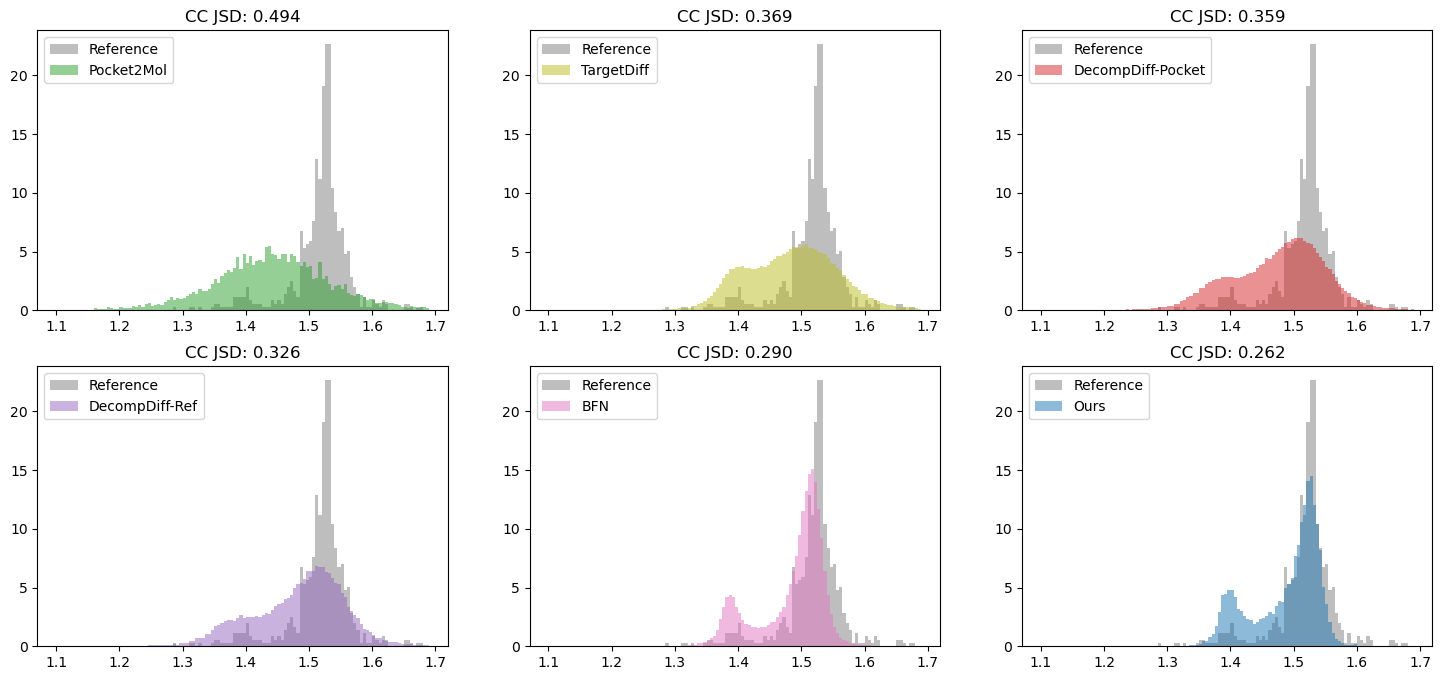

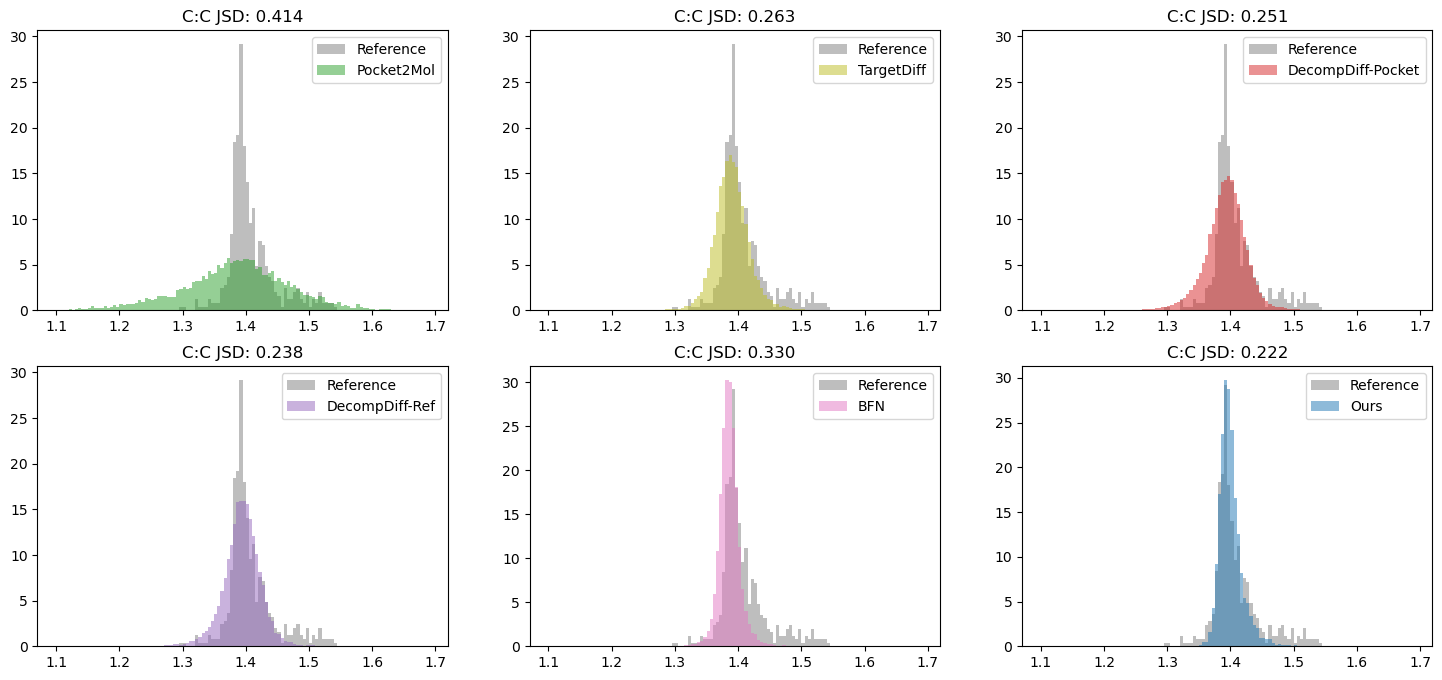

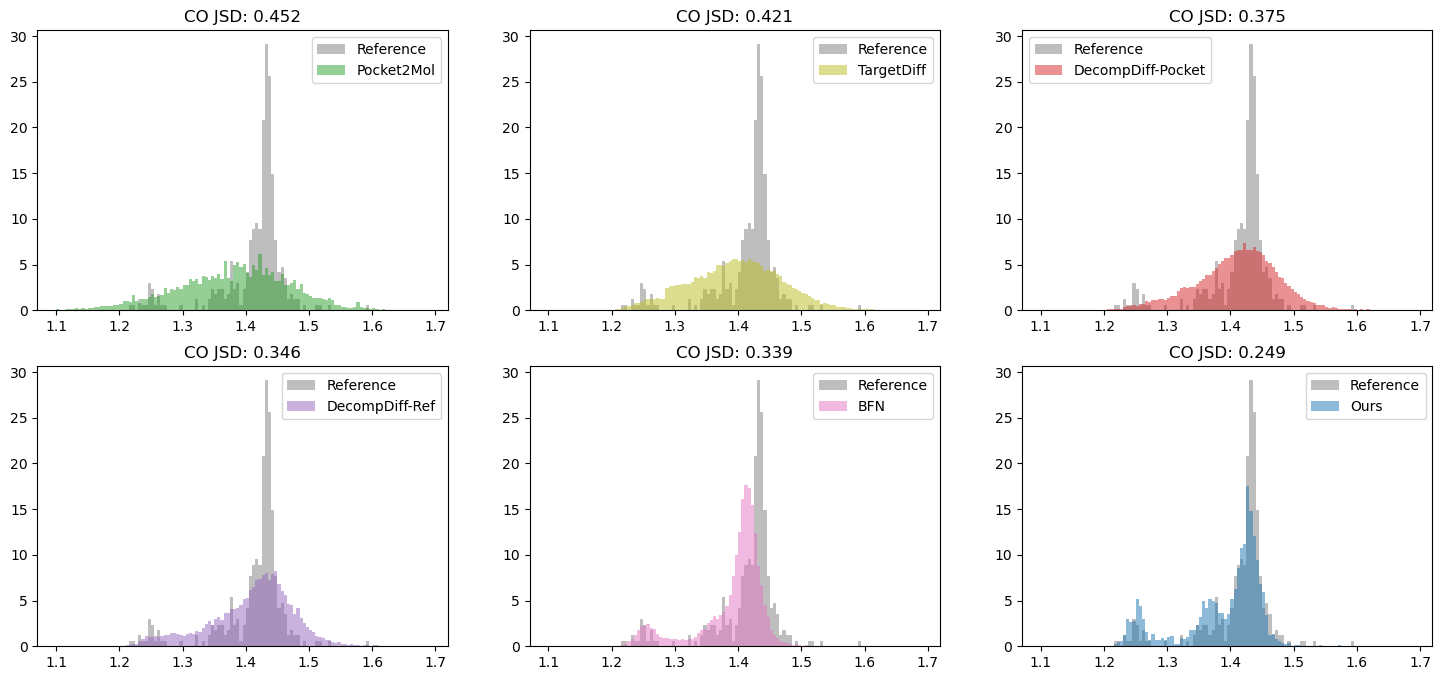

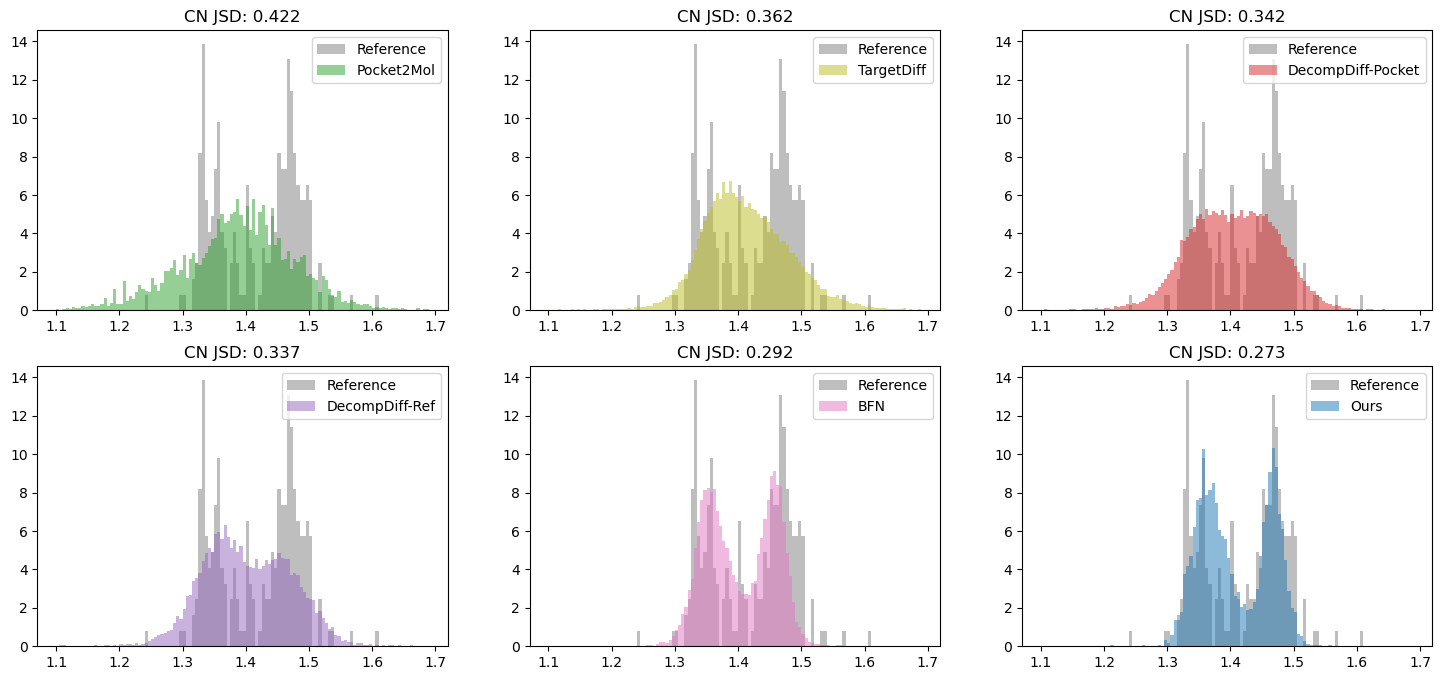

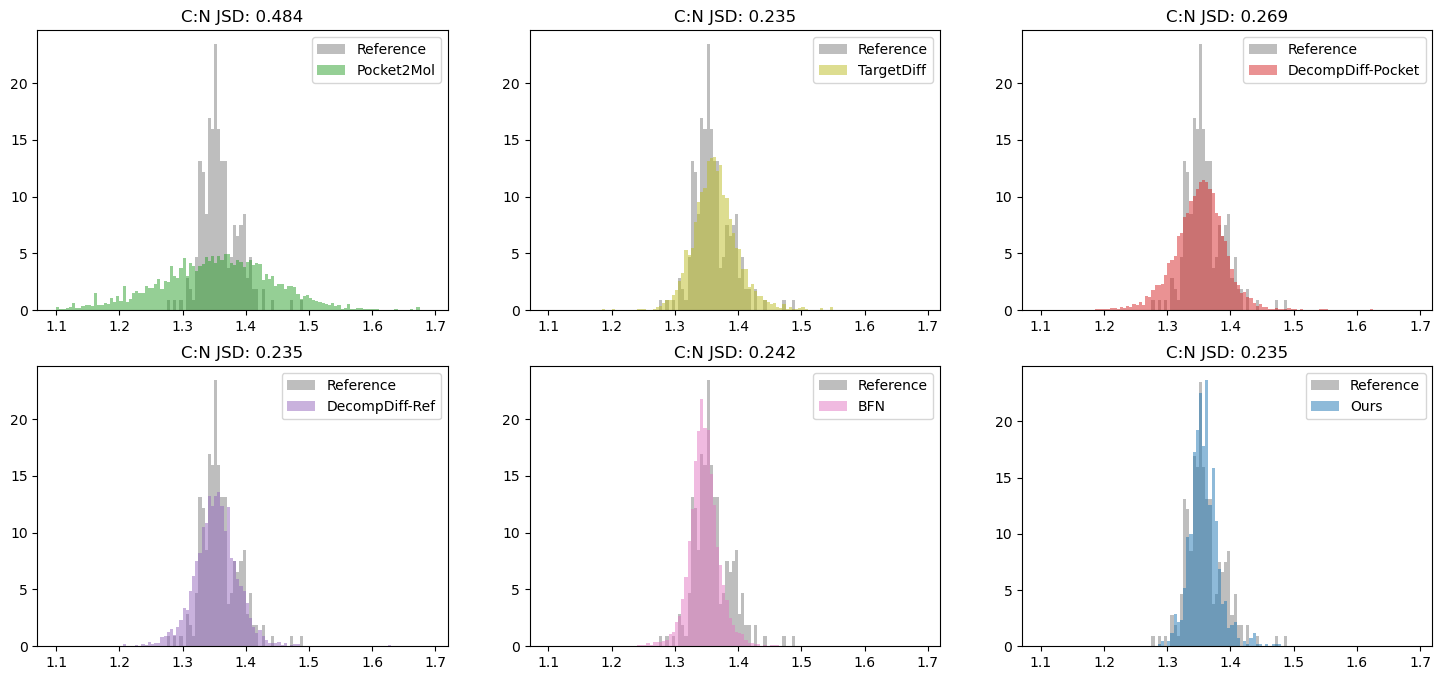

In [11]:
from scipy import spatial as sci_spatial
# from core.evaluation.utils import discrepancy

BOND_LENGTH_BINS = np.arange(1.1, 1.7, 0.005)[:-1]
colors = ['tab:blue', 'tab:green', 'tab:olive', 'tab:red', 'tab:purple', 'tab:pink', 'tab:blue', 'tab:cyan', 'tab:orange', 'tab:gray', 'tab:brown'] 

for bond_type in allowed_bond_types:
    plt.figure(figsize=(6 * 3, 4 * 2))
    ref_min, ref_max = np.min(ref_profile[bond_type]), np.max(ref_profile[bond_type])
    for idx, model in enumerate(models):       
        # plt.figure()
        model_min, model_max = np.min(profiles[idx][bond_type]), np.max(profiles[idx][bond_type])
        min_val, max_val = min(ref_min, model_min), max(ref_max, model_max)
        # bins = np.linspace(min_val, max_val, N_BINS + 1)
        ref_dist = np.histogram(ref_profile[bond_type], bins=BOND_LENGTH_BINS, density=True)[0]
        model_dist = np.histogram(profiles[idx][bond_type], bins=BOND_LENGTH_BINS, density=True)[0]
        jsd = sci_spatial.distance.jensenshannon(ref_dist, model_dist)
        # emd = discrepancy.compute_mmd([ref_dist], [model_dist], is_hist=False, kernel=discrepancy.gaussian_emd)
        # mmd = discrepancy.compute_mmd([ref_dist], [model_dist], is_hist=False, kernel=discrepancy.gaussian_tv)
        plt.subplot(2, 3, idx+1) 
        plt.hist(ref_profile[bond_type], bins=BOND_LENGTH_BINS, label='Reference', alpha=0.5, color='tab:gray', density=True)
        # plt.hist(profiles[idx][bond_type], bins=BOND_LENGTH_BINS, label=model.name, alpha=0.5, color=color_mapping[model.name], density=True)
        plt.hist(profiles[idx][bond_type], bins=BOND_LENGTH_BINS, label=model.name, alpha=0.5, color=colors[idx+1], density=True)
        plt.title(eval_bond_length._bond_type_str(bond_type) + f' JSD: {jsd:.3f}')   
        plt.legend()
        # plt.savefig(f'./{eval_bond_length._bond_str(bond_type)}_{model.name}.png')
    plt.savefig(f'figs/{eval_bond_length._bond_type_str(bond_type)}_fit.png', dpi=300, bbox_inches='tight')
    plt.show()   

In [ ]:
from scipy import spatial as sci_spatial
# from core.evaluation.utils import discrepancy

BOND_LENGTH_BINS = np.arange(1.1, 1.7, 0.005)[:-1]
colors = ['tab:blue', 'tab:green', 'tab:olive', 'tab:red', 'tab:purple', 'tab:pink', 'tab:cyan', 'tab:orange', 'tab:gray', 'tab:brown'] 
colors_more = [c.replace('tab:', '') for c in colors]

new_allowed_bond_types = []
for bond_type in allowed_bond_types:
    if bond_type[-1] == 4: continue
    new_allowed_bond_types.append(bond_type)

for bond_type in new_allowed_bond_types:
    plt.figure(figsize=(6 * 3, 4 * 2))
    ref_min, ref_max = np.min(ref_profile[bond_type]), np.max(ref_profile[bond_type])
    bone_type_str = eval_bond_length._bond_str(bond_type)
    print(bond_type, bone_type_str)

    for idx, model in enumerate(models):  
        # plt.figure()
        model_min, model_max = np.min(profiles[idx][bond_type]), np.max(profiles[idx][bond_type])
        min_val, max_val = min(ref_min, model_min), max(ref_max, model_max)
        # bins = np.linspace(min_val, max_val, N_BINS + 1)
        ref_dist = np.histogram(ref_profile[bond_type], bins=BOND_LENGTH_BINS, density=True)[0]
        model_dist = np.histogram(profiles[idx][bond_type], bins=BOND_LENGTH_BINS, density=True)[0]
        jsd = sci_spatial.distance.jensenshannon(ref_dist, model_dist)
        # emd = discrepancy.compute_mmd([ref_dist], [model_dist], is_hist=False, kernel=discrepancy.gaussian_emd)
        # mmd = discrepancy.compute_mmd([ref_dist], [model_dist], is_hist=False, kernel=discrepancy.gaussian_tv)
        plt.subplot(2, 3, idx+1) 
    
        plt.hist(ref_profile[bond_type], bins=BOND_LENGTH_BINS, label=f'Reference ({eval_bond_length._bond_str(bond_type)})', alpha=0.5, color='tab:gray', density=True)
        # plt.hist(profiles[idx][bond_type], bins=BOND_LENGTH_BINS, label=model.name, alpha=0.5, color=color_mapping[model.name], density=True)
        plt.hist(profiles[idx][bond_type], bins=BOND_LENGTH_BINS, label=f'{model.name} ({eval_bond_length._bond_str(bond_type)})', alpha=0.5, color=colors[idx+1], density=True)
        title = eval_bond_length._bond_str(bond_type) + f' JSD: {jsd:.3f}'
        print(title)
        if bond_type[1] != 8:
            aromatic_bond_type = (bond_type[0], bond_type[1], 4)
            aromatic_bond_type_str = eval_bond_length._bond_str(aromatic_bond_type)
            print(bond_type, bond_type_str, aromatic_bond_type_str)
            plt.hist(ref_profile[aromatic_bond_type_str], bins=BOND_LENGTH_BINS, label=f'Reference ({eval_bond_length._bond_str(aromatic_bond_type)})', alpha=0.5, color='gray', density=True)
            # plt.hist(profiles[idx][bond_type], bins=BOND_LENGTH_BINS, label=model.name, alpha=0.5, color=color_mapping[model.name], density=True)
            plt.hist(profiles[idx][bond_type], bins=BOND_LENGTH_BINS, label=f'{model.name} ({eval_bond_length._bond_str(aromatic_bond_type)})', alpha=0.5, color=colors_more[idx+1], density=True)
            title += ' ' + aromatic_bond_type_str + f' JSD: {jsd:.3f}'

        plt.title(title)   
        plt.legend()
    plt.savefig(f'./all.png')
    plt.show()   

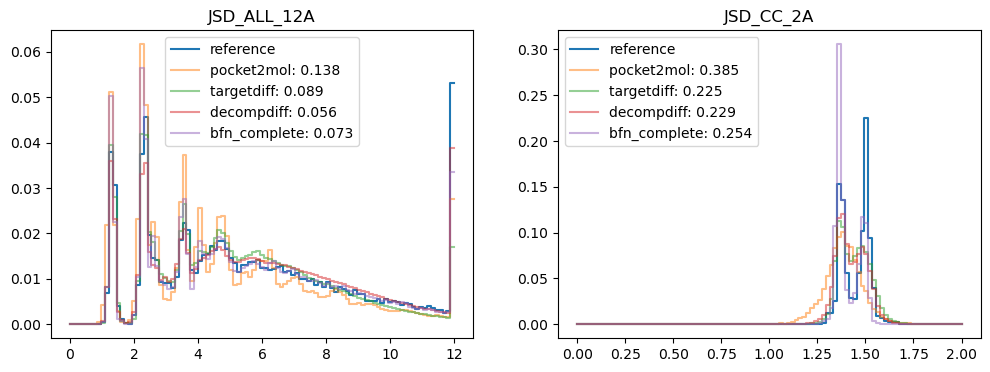

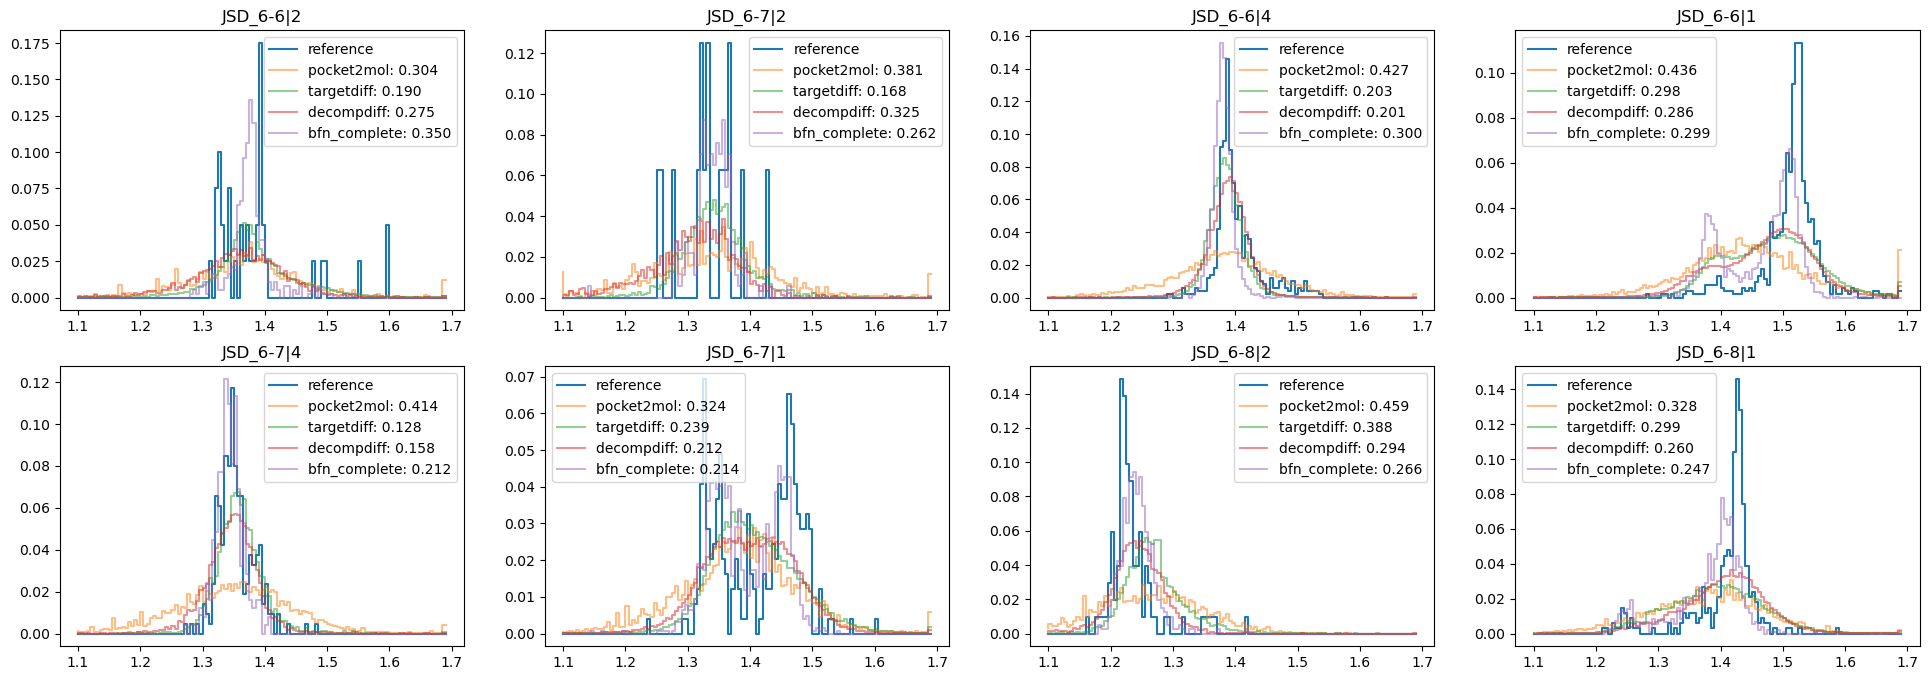

In [37]:
from core.evaluation.utils import eval_bond_length
from core.evaluation.utils.eval_bond_length_config import PAIR_EMPIRICAL_BINS, DISTANCE_BINS, BOND_TYPES

ALL_ATOM_BINS = PAIR_EMPIRICAL_BINS['All_12A']
CC_BINS = PAIR_EMPIRICAL_BINS['CC_2A']
OTHER_BINS = DISTANCE_BINS

def compute_jsd(ref_dist_list, dist_list, bins):
    ref_profile = eval_bond_length.get_distribution(ref_dist_list, bins=bins)
    profile = eval_bond_length.get_distribution(dist_list, bins=bins)
    return ref_profile, profile, sci_spatial.distance.jensenshannon(ref_profile, profile)


def get_metrics(ref, model):
    atom_distance = model.all_atom_distance
    c_c_distance = model.all_c_c_distance
    ref_atom_dist, atom_dist, jsd_atom = compute_jsd(ref.all_atom_distance, atom_distance, ALL_ATOM_BINS)
    ref_cc_dist, cc_dist, jsd_c_c = compute_jsd(ref.all_c_c_distance, c_c_distance, CC_BINS)
    _metrics = eval_bond_length.eval_bond_length_profile(model.bond_length_profile)
    ref.atom_dist = ref_atom_dist
    ref.cc_dist = ref_cc_dist
    model.atom_dist = atom_dist
    model.cc_dist = cc_dist
    _metrics['ALL_12A'] = jsd_atom
    _metrics['CC_2A'] = jsd_c_c
    model.metrics = _metrics
    return _metrics
    
p2m_metrics = get_metrics(ref, p2m)
tg_metrics = get_metrics(ref, tg)
dcmp_metrics = get_metrics(ref, dcmp)
bfn_metrics = get_metrics(ref, bfn)
models = [p2m, tg, dcmp, bfn]

ALPHA = 0.5

plt.figure(figsize=(6 * 2, 4))
plt.subplot(1, 2, 1)
plt.step(ALL_ATOM_BINS, ref.atom_dist[1:], label=f'reference')
for model in models:
    plt.step(ALL_ATOM_BINS, model.atom_dist[1:], alpha=ALPHA, label=f'{model.name}: {model.metrics["ALL_12A"]:.3f}')
plt.legend()
plt.title(f'JSD_ALL_12A')
plt.subplot(1, 2, 2)
plt.step(CC_BINS, ref.cc_dist[1:], label=f'reference')
for model in models:
    plt.step(CC_BINS, model.cc_dist[1:], alpha=ALPHA, label=f'{model.name}: {model.metrics["CC_2A"]:.3f}')
plt.legend()
plt.title(f'JSD_CC_2A')
plt.show()

plt.figure(figsize=(6 * 4, 4 * 2))
for idx, k in enumerate(BOND_TYPES):
    bins = OTHER_BINS
    _str = eval_bond_length._bond_type_str(k)
    plt.subplot(2, 4, idx + 1)
    plt.step(bins, ref.bond_length_profile[k][1:], label=f'reference')
    for model in models:
        plt.step(bins, model.bond_length_profile[k][1:], alpha=ALPHA, label=f'{model.name}: {model.metrics[f"JSD_{_str}"]:.3f}')
    plt.legend()
    plt.title(f'JSD_{_str}')
plt.show()



## Bond Angle

(6, 1, 6, 1, 6), #	CCC	521	18.1%	59.52230720788234	135.50315793532704	0.759808507274447
(6, 4, 6, 4, 6), #	C:C:C	460	16.0%	101.54806405949785	127.54928623790771	0.2600122217840986
(6, 1, 6, 1, 8), #	CCO	274	9.5%	57.19735111082594	136.5409407542893	0.7934358964346336


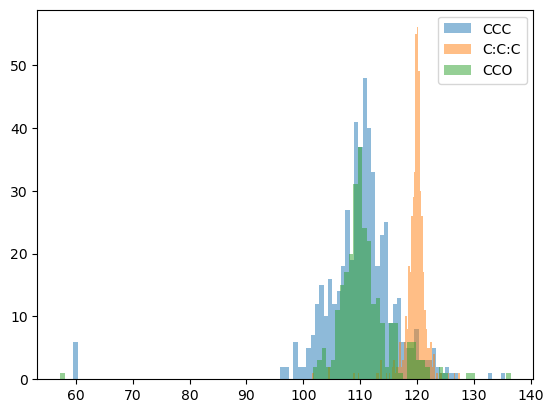

In [6]:
from core.evaluation.utils import eval_bond_angle

bond_angles = []
for res in ref.flat_results:
    mol = res['mol']
    mol = Chem.RemoveAllHs(mol)
    bond_angles += eval_bond_angle.bond_angle_from_mol(mol)

profile = eval_bond_angle.get_bond_angles(bond_angles)

N_BINS = 100

allowed_angle_types = []
for k, v in sorted(profile.items(), key=lambda x: len(x[1]), reverse=True):
    freq = len(v)
    rate = freq / len(bond_angles) * 100
    if freq < 10:
        continue

    if freq > 250:
        allowed_angle_types.append(k)
        angle_type_str = eval_bond_angle._angle_type_str(k)
        plt.hist(profile[k], bins=N_BINS, label=angle_type_str, alpha=0.5)
        min_val, max_val = np.min(profile[k]), np.max(profile[k])
        bin_width = (max_val - min_val) / N_BINS
        print(f'{k}, #\t{angle_type_str}\t{freq}\t{rate:.1f}%\t{min_val}\t{max_val}\t{bin_width}')
plt.legend()
plt.show()

In [7]:
ref_profile = profile
profiles = []

for model in models:
    bond_angles = []
    for res in model.flat_results:
        mol = res['mol']
        mol = Chem.RemoveAllHs(mol)
        bond_angles += eval_bond_angle.bond_angle_from_mol(mol)
    profiles.append(eval_bond_angle.get_bond_angles(bond_angles))


[100.   100.25 100.5  100.75 101.   101.25 101.5  101.75 102.   102.25
 102.5  102.75 103.   103.25 103.5  103.75 104.   104.25 104.5  104.75
 105.   105.25 105.5  105.75 106.   106.25 106.5  106.75 107.   107.25
 107.5  107.75 108.   108.25 108.5  108.75 109.   109.25 109.5  109.75
 110.   110.25 110.5  110.75 111.   111.25 111.5  111.75 112.   112.25
 112.5  112.75 113.   113.25 113.5  113.75 114.   114.25 114.5  114.75
 115.   115.25 115.5  115.75 116.   116.25 116.5  116.75 117.   117.25
 117.5  117.75 118.   118.25 118.5  118.75 119.   119.25 119.5  119.75
 120.   120.25 120.5  120.75 121.   121.25 121.5  121.75 122.   122.25
 122.5  122.75 123.   123.25 123.5  123.75 124.   124.25 124.5  124.75
 125.   125.25 125.5  125.75 126.   126.25 126.5  126.75 127.   127.25
 127.5  127.75 128.   128.25 128.5  128.75 129.   129.25 129.5  129.75
 130.   130.25 130.5  130.75 131.   131.25 131.5  131.75 132.   132.25
 132.5  132.75 133.   133.25 133.5  133.75 134.   134.25 134.5  134.75
 135. 

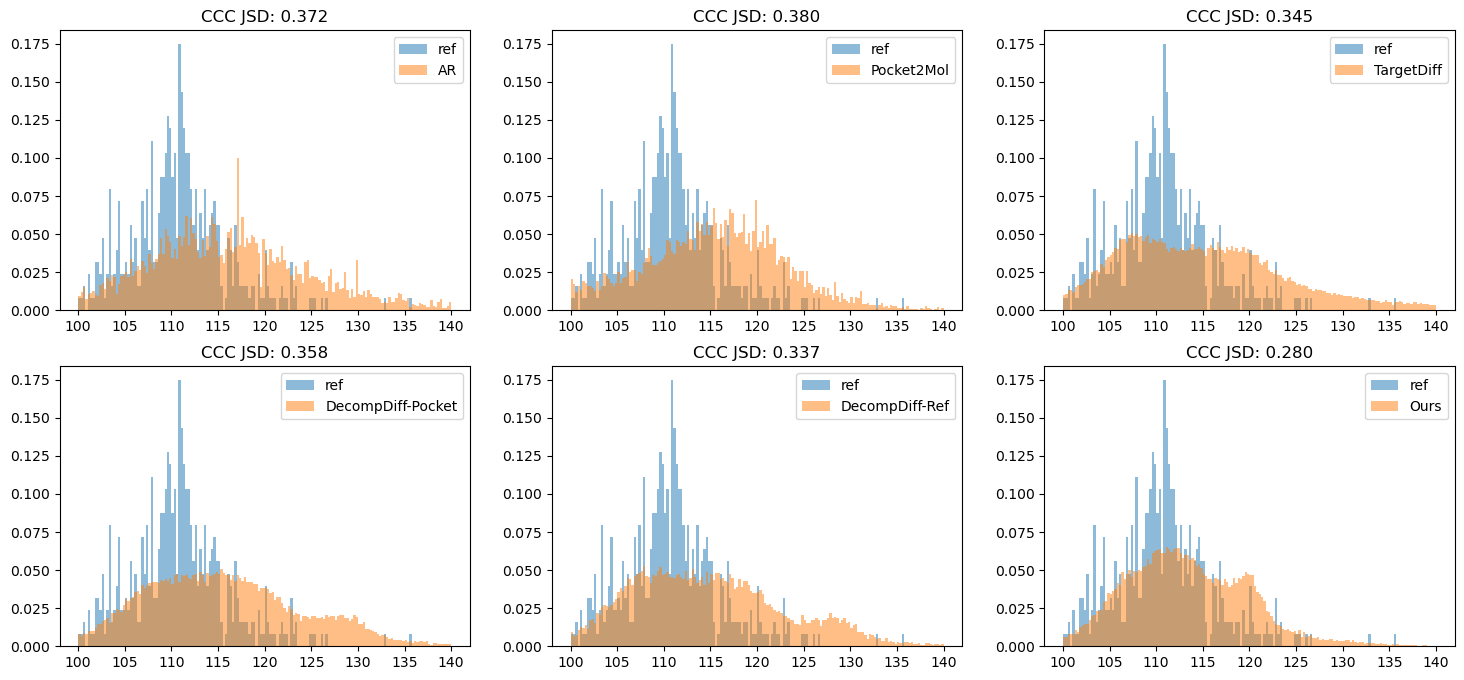

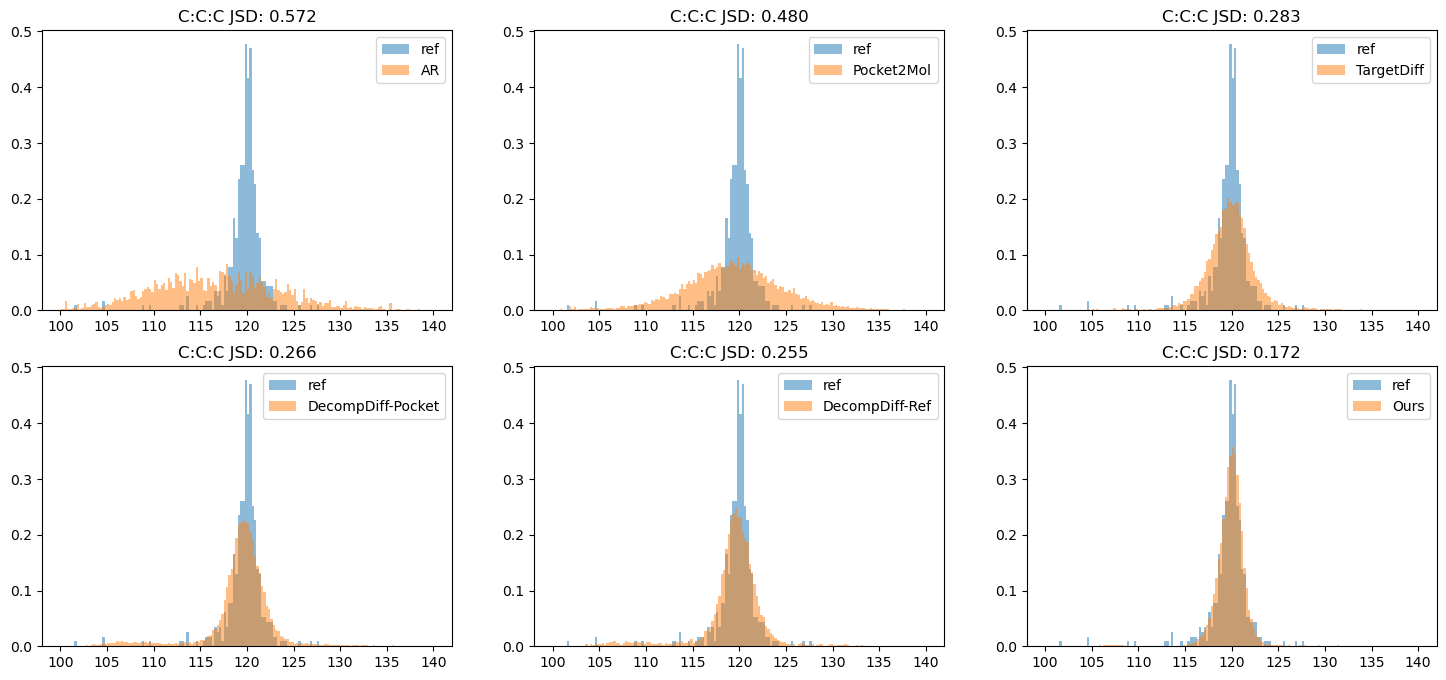

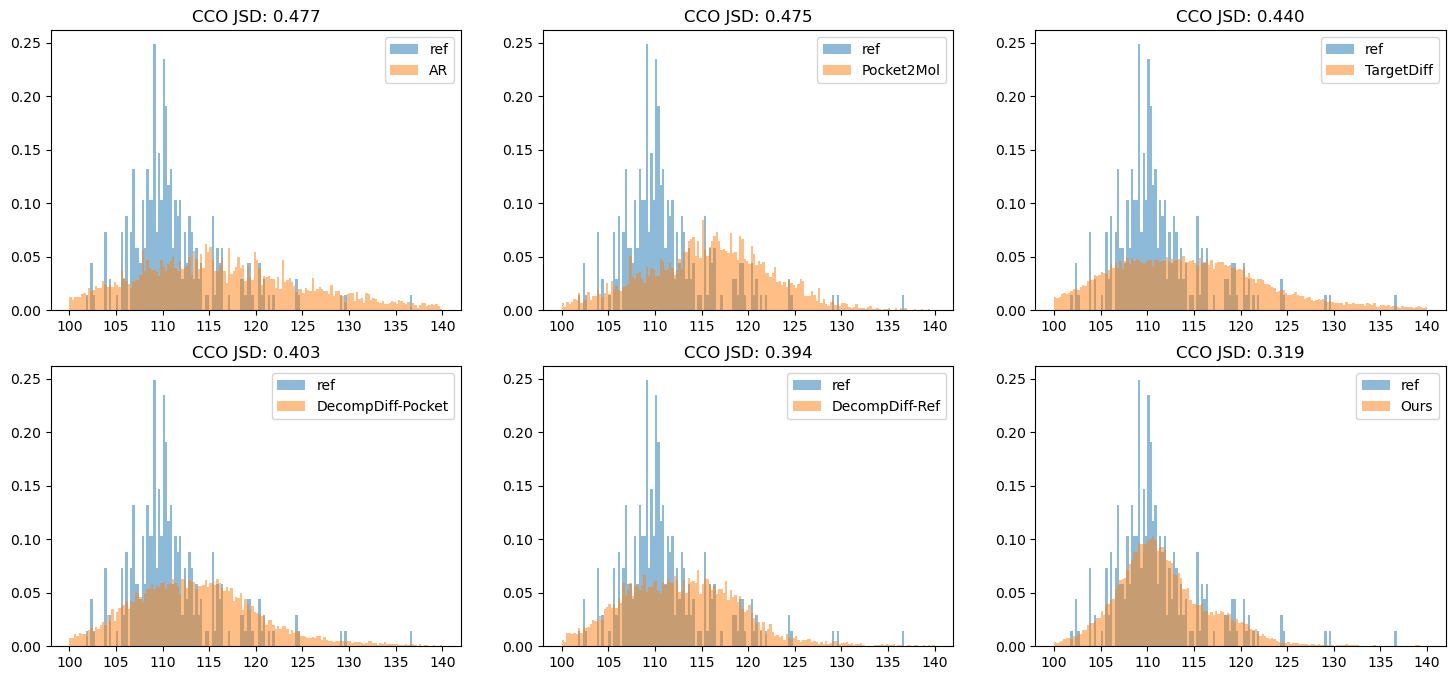

In [8]:
N_BINS = np.arange(100, 140.25, 0.25)
print(N_BINS)

for angle_type in allowed_angle_types:
    plt.figure(figsize=(6 * 3, 4 * 2))
    ref_min, ref_max = np.min(ref_profile[angle_type]), np.max(ref_profile[angle_type])
    for idx, model in enumerate(models):       
        model_min, model_max = np.min(profiles[idx][angle_type]), np.max(profiles[idx][angle_type])
        min_val, max_val = min(ref_min, model_min), max(ref_max, model_max)
        # bins = np.linspace(min_val, max_val, N_BINS + 1)
        ref_dist = np.histogram(ref_profile[angle_type], bins=N_BINS, density=True)[0]
        model_dist = np.histogram(profiles[idx][angle_type], bins=N_BINS, density=True)[0]
        jsd = sci_spatial.distance.jensenshannon(ref_dist, model_dist)
        # emd = discrepancy.compute_mmd([ref_dist], [model_dist], is_hist=False, kernel=discrepancy.gaussian_emd)
        # mmd = discrepancy.compute_mmd([ref_dist], [model_dist], is_hist=False, kernel=discrepancy.gaussian_tv)
        plt.subplot(2, 3, idx+1) 
        plt.hist(ref_profile[angle_type], bins=N_BINS, label='ref', alpha=0.5, density=True)
        plt.hist(profiles[idx][angle_type], bins=N_BINS, label=model.name, alpha=0.5, density=True)
        plt.title(eval_bond_angle._angle_type_str(angle_type) + f' JSD: {jsd:.3f}')   
        plt.legend()
    plt.show()   

## Torsion Angle

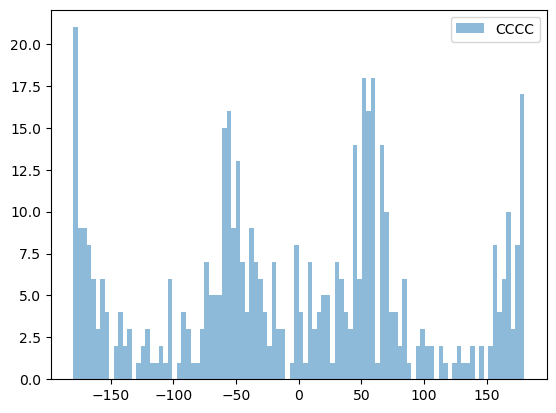

(6, 1, 6, 1, 6, 1, 6), #	CCCC	486	13.7%	-179.92344102773612	179.9786281079837	3.599020691357198


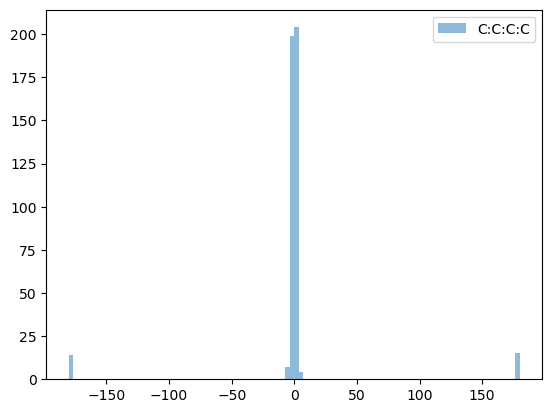

(6, 4, 6, 4, 6, 4, 6), #	C:C:C:C	443	12.5%	-179.97199569192466	179.98934915798304	3.599613448499077


In [5]:
from core.evaluation.utils import eval_torsion_angle

torsion_angles = []
for res in ref.flat_results:
    mol = res['mol']
    mol = Chem.RemoveAllHs(mol)
    torsion_angles += eval_torsion_angle.torsion_angle_from_mol(mol)

profile = eval_torsion_angle.get_torsion_angles(torsion_angles)
N_BINS = 100

allowed_torsion_types = []
for k, v in sorted(profile.items(), key=lambda x: len(x[1]), reverse=True):
    freq = len(v)
    rate = freq / len(torsion_angles) * 100
    if freq < 10:
        continue

    if freq > 200:
        allowed_torsion_types.append(k)
        torsion_type_str = eval_torsion_angle._torsion_type_str(k)
        plt.hist(profile[k], bins=N_BINS, label=torsion_type_str, alpha=0.5, density=False)
        plt.legend()
        plt.show()
        min_val, max_val = np.min(profile[k]), np.max(profile[k])
        bin_width = (max_val - min_val) / N_BINS
        print(f'{k}, #\t{torsion_type_str}\t{freq}\t{rate:.1f}%\t{min_val}\t{max_val}\t{bin_width}')



In [6]:
ref_profile = profile
profiles = []
# models = [p2m, tg, dcmp, bfn, bfn_mols, bfn_mols_v1]

for model in models:
    torsion_angles = []
    for res in model.flat_results:
        mol = res['mol']
        mol = Chem.RemoveAllHs(mol)
        torsion_angles += eval_torsion_angle.torsion_angle_from_mol(mol)
    profiles.append(eval_torsion_angle.get_torsion_angles(torsion_angles))


[-180 -177 -174 -171 -168 -165 -162 -159 -156 -153 -150 -147 -144 -141
 -138 -135 -132 -129 -126 -123 -120 -117 -114 -111 -108 -105 -102  -99
  -96  -93  -90  -87  -84  -81  -78  -75  -72  -69  -66  -63  -60  -57
  -54  -51  -48  -45  -42  -39  -36  -33  -30  -27  -24  -21  -18  -15
  -12   -9   -6   -3    0    3    6    9   12   15   18   21   24   27
   30   33   36   39   42   45   48   51   54   57   60   63   66   69
   72   75   78   81   84   87   90   93   96   99  102  105  108  111
  114  117  120  123  126  129  132  135  138  141  144  147  150  153
  156  159  162  165  168  171  174  177  180]


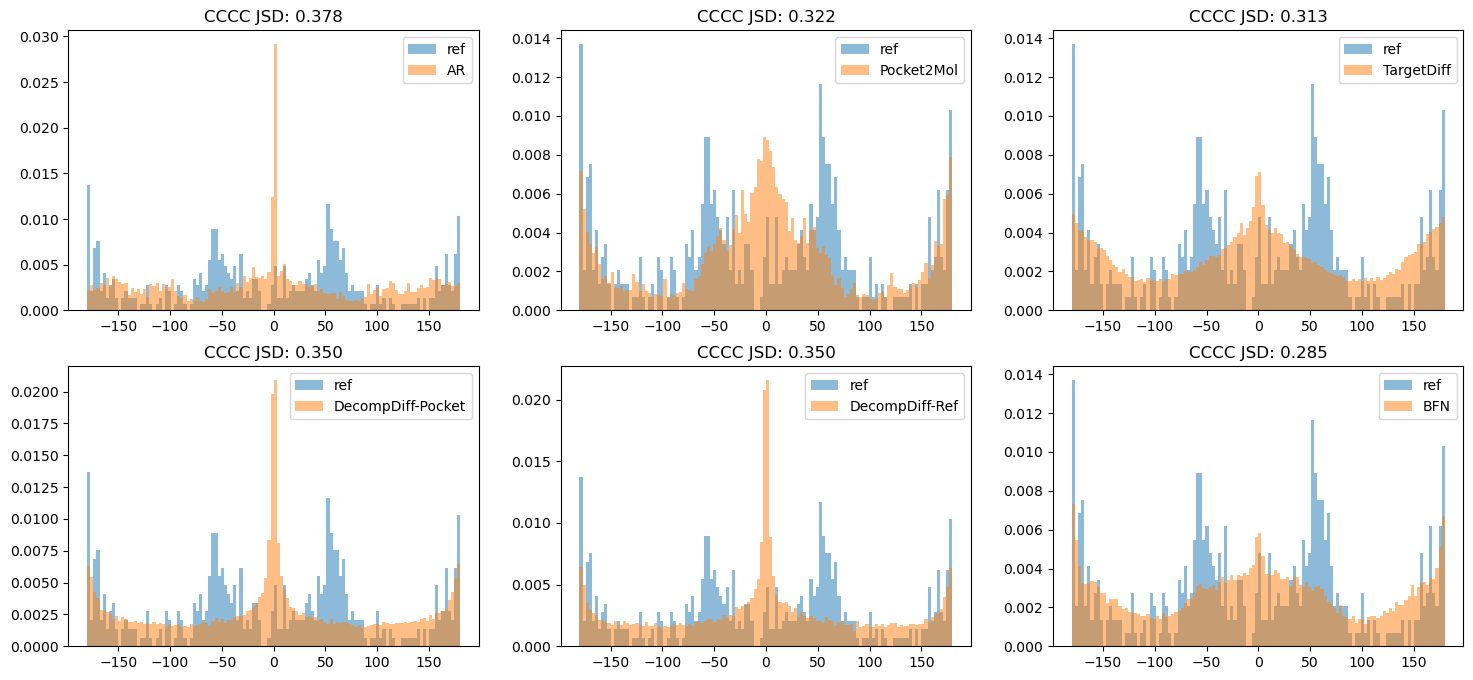

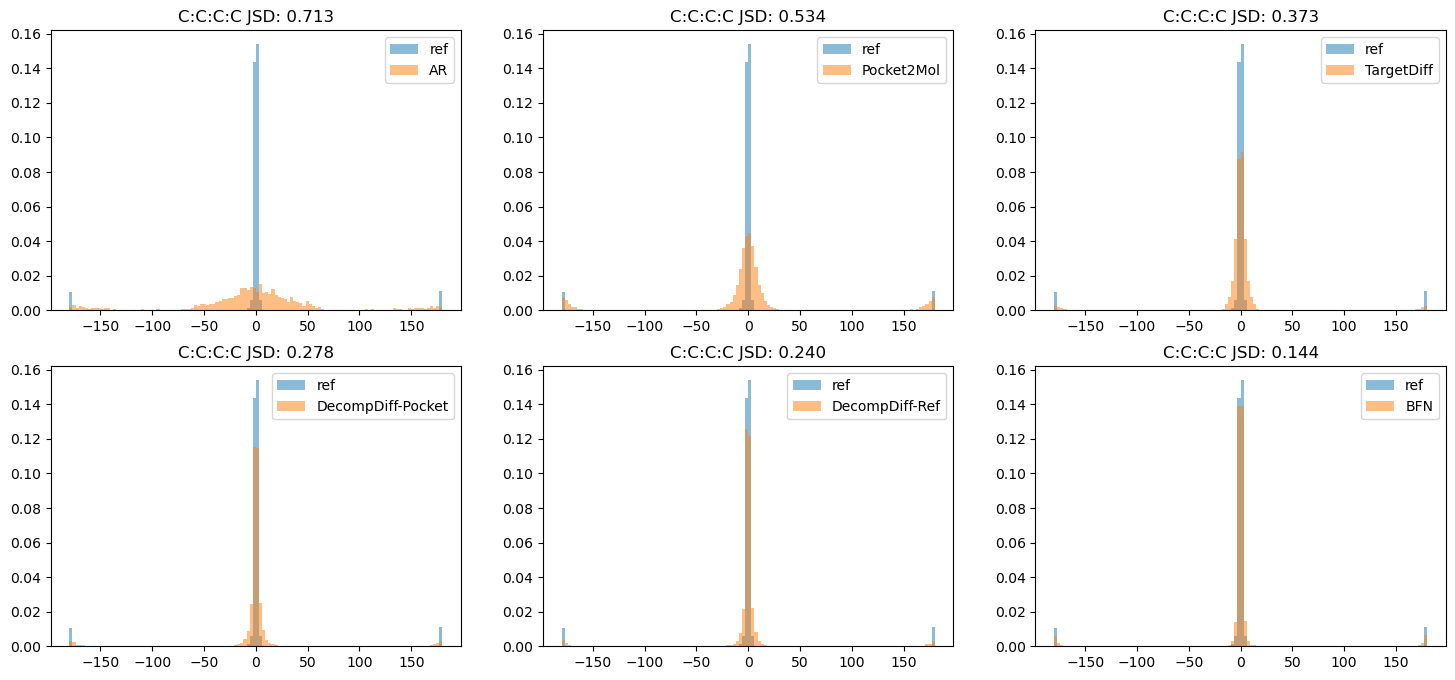

In [8]:
N_BINS = np.arange(-180, 181, 3)
print(N_BINS)

for torsion_type in allowed_torsion_types:
    plt.figure(figsize=(6 * 3, 4 * 2))
    ref_min, ref_max = np.min(ref_profile[torsion_type]), np.max(ref_profile[torsion_type])
    for idx, model in enumerate(models):
        model_min, model_max = np.min(profiles[idx][torsion_type]), np.max(profiles[idx][torsion_type])
        min_val, max_val = min(ref_min, model_min), max(ref_max, model_max)
        ref_dist = np.histogram(ref_profile[torsion_type], bins=N_BINS, density=True)[0]
        model_dist = np.histogram(profiles[idx][torsion_type], bins=N_BINS, density=True)[0]
        jsd = sci_spatial.distance.jensenshannon(ref_dist, model_dist)
        plt.subplot(2, 3, idx+1) 
        plt.hist(ref_profile[torsion_type], bins=N_BINS, label='ref', alpha=0.5, density=True)
        plt.hist(profiles[idx][torsion_type], bins=N_BINS, label=model.name, alpha=0.5, density=True)
        plt.title(eval_torsion_angle._torsion_type_str(torsion_type) + f' JSD: {jsd:.3f}')   
        plt.legend()
    plt.show()   
